In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from IPython.display import display

In [10]:
# 数据集定义
class MyDataset(Dataset):
    def __init__(self, mode, data_path):
        super(MyDataset, self).__init__()
        assert mode in ['train', 'val', 'test']
        data = np.load(data_path)
        length = len(data)
        if mode == 'train':
            # self.data = data[:int(0.6 * length)]
            self.data = data
        elif mode == 'val':
            self.data = data[int(0.6 * length) : int(0.8*length)]
        else:
            self.data = data[int(0.8*length):]

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

In [11]:
# 模型定义
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.linear_0 = nn.Linear(1,1,bias=True)

    def forward(self, x):
        y = self.linear_0(x.unsqueeze(-1))
        return y

class MyModel_1(nn.Module):
    def __init__(self):
        super(MyModel_1, self).__init__()
        self.linear_0 = nn.Linear(1,3)
        self.linear_1 = nn.Linear(3,3)
        self.linear_2 = nn.Linear(3,1)
    
    def forward(self, x):
        x = self.linear_0(x.unsqueeze(-1))
        x = self.linear_1(x)
        y = self.linear_2(x)
        return y


In [12]:
# 损失函数定义
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
    
    def forward(self, x, y):
        distance = 1/2 * (y - x) ** 2
        loss = torch.sum(distance)
        loss_mean = loss / x.shape[0]
        return loss_mean

In [37]:
# 超参数设置
batch_size = 16
num_workers = 0
# lr = 0.001
lr = 0.001
epochs = 1000

In [38]:
# 初始化
data_shuffle_path = '../data/linear_data/linear_shuffle_data.npy'
data_scatter_path = '../data/linear_data/linear_scatter_data.npy'
data_true_path    = '../data/linear_data/linear_true_data.npy'

data_shuffle = np.load(data_shuffle_path)
data_scatter = np.load(data_scatter_path)
data_true = np.load(data_true_path)

train_data = MyDataset('train', data_shuffle_path)
val_data   = MyDataset('val', data_shuffle_path)
test_data  = MyDataset('test', data_shuffle_path)
train_dataloader = DataLoader(train_data, 
                              batch_size=batch_size, 
                              num_workers=num_workers, 
                              drop_last=True, 
                              shuffle=True)
val_dataloader   = DataLoader(val_data, 
                              batch_size=1, 
                              num_workers=num_workers)
test_dataloader  = DataLoader(test_data, 
                              batch_size=1, 
                              num_workers=num_workers)
model = MyModel()
model_1 = MyModel_1()
loss_f = Loss()
optimizer = SGD(model.parameters(),
            lr=lr)

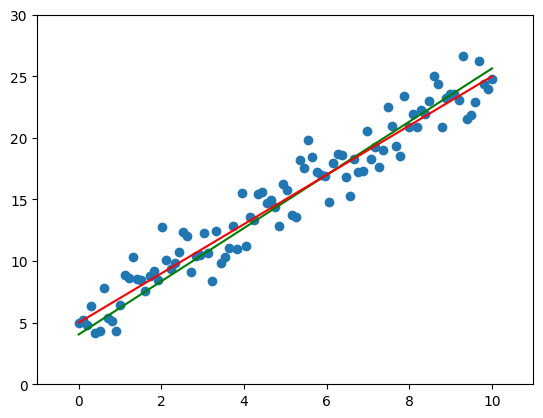

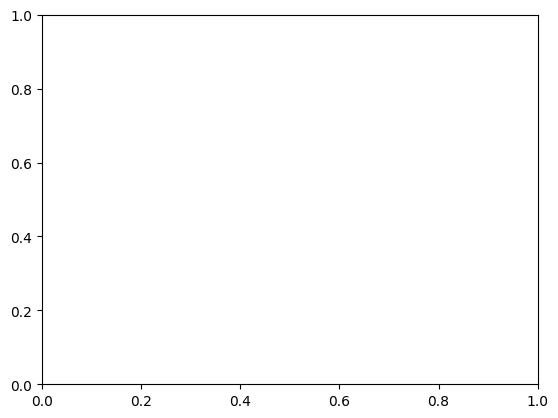

In [39]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlim(-1, 11)
ax.set_ylim(0, 25)
display(fig, display_id='plot')
for epoch in range(epochs):
    for data in train_dataloader:
        output = model(data[:,0])
        loss = loss_f(output.squeeze(-1), data[:,1])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # loss_sum = 0
    # with torch.no_grad():
    #     for data in val_dataloader:
    #         output = model(data[:,0])
    #         loss = loss_f(output, data[:,1])
    #         loss_sum = loss_sum + loss

    with torch.no_grad():
        y_show = model(torch.tensor(data_true[:,0]))
    ax.set_xlim(-1, 11)
    ax.set_ylim(0, 30)
    ax.scatter(data_scatter[:,0], data_scatter[:,1])
    ax.plot(data_true[:,0], y_show, color='green')
    ax.plot(data_true[:,0], data_true[:,1], color='red')
    display(fig, display_id='plot',update=True)
    fig.savefig(f'save_img/{str(epoch).zfill(6)}.jpg')
    ax.clear()
# loss_sum = 0
# for data in  test_dataloader:
#     output = model(data[:,0])
#     loss = loss_f(output, data[:,1])
#     loss_sum = loss_sum + loss

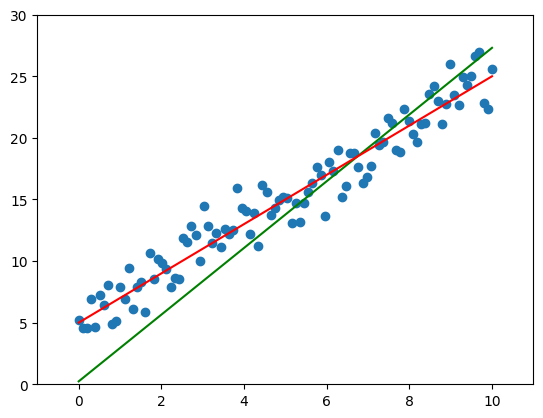

tensor(4390.9502)
tensor(4349.1240)
tensor(4306.5117)
tensor(4263.0498)
tensor(4218.6787)
tensor(4173.3350)
tensor(4126.9590)
tensor(4079.4910)
tensor(4030.8701)
tensor(3981.0371)
tensor(3929.9348)
tensor(3877.5068)
tensor(3823.6965)
tensor(3768.4512)
tensor(3711.7195)
tensor(3653.4553)
tensor(3593.6123)
tensor(3532.1504)
tensor(3469.0352)
tensor(3404.2366)
tensor(3337.7300)
tensor(3269.4993)
tensor(3199.5374)
tensor(3127.8462)
tensor(3054.4360)
tensor(2979.3320)
tensor(2902.5688)
tensor(2824.1975)
tensor(2744.2822)
tensor(2662.9036)
tensor(2580.1589)
tensor(2496.1631)
tensor(2411.0493)
tensor(2324.9697)
tensor(2238.0942)
tensor(2150.6118)
tensor(2062.7288)
tensor(1974.6693)
tensor(1886.6715)
tensor(1798.9886)
tensor(1711.8838)
tensor(1625.6296)
tensor(1540.5031)
tensor(1456.7825)
tensor(1374.7437)
tensor(1294.6564)
tensor(1216.7783)
tensor(1141.3524)
tensor(1068.6031)
tensor(998.7307)
tensor(931.9089)
tensor(868.2829)
tensor(807.9662)
tensor(751.0408)
tensor(697.5536)
tensor(647.5199)

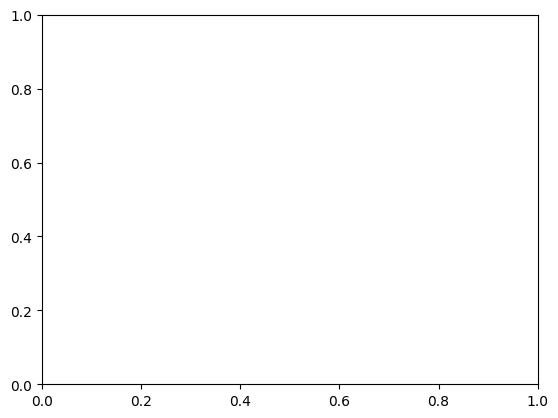

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlim(-1, 11)
ax.set_ylim(0, 25)
display(fig, display_id='plot')
for epoch in range(epochs):
    for data in train_dataloader:
        output = model_1(data[:,0])
        loss = loss_f(output.squeeze(-1), data[:,1])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # loss_sum = 0
    # with torch.no_grad():
    #     for data in val_dataloader:
    #         output = model(data[:,0])
    #         loss = loss_f(output, data[:,1])
    #         loss_sum = loss_sum + loss

    with torch.no_grad():
        y_show = model(torch.tensor(data_true[:,0]))
    ax.set_xlim(-1, 11)
    ax.set_ylim(0, 30)
    ax.scatter(data_scatter[:,0], data_scatter[:,1])
    ax.plot(data_true[:,0], y_show, color='green')
    ax.plot(data_true[:,0], data_true[:,1], color='red')
    display(fig, display_id='plot',update=True)
    ax.clear()
# loss_sum = 0
# for data in  test_dataloader:
#     output = model(data[:,0])
#     loss = loss_f(output, data[:,1])
#     loss_sum = loss_sum + loss